## Import libraries

In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics 
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta


## Load and prepare data

In [19]:
excelPath = "vyhodnoceni_cilene_kampane_zadani.xlsx"
target = pd.read_excel(io=excelPath,sheet_name='Target')
control = pd.read_excel(io=excelPath,sheet_name='Control')
purchases = pd.read_excel(io=excelPath,sheet_name='Purchases')
purchases.rename(columns={'customer_id ': 'customer_id'},inplace=True)

#format months to datetime
purchases['purchase_month'] = pd.to_datetime(purchases['purchase_month'],format="%Y-%b")#.dt.strftime("%Y-%b")
target['target_month'] = pd.to_datetime(target['target_month'],format="%Y-%b")#.dt.strftime("%Y-%b")

Function which adds missing values to dataframe for months November 2013 and 2012. Missing data are filled with average values.

In [3]:
def add_mean_values(df):
    data = {'purchase_amount':df[(df.index < '2013-01-01') | (df.index > '2013-05-01')].purchase_amount.mean()}
    df = df.append(pd.DataFrame(data, index=[datetime.datetime(2013, 11, 1)]))
    df = df.append(pd.DataFrame(data, index=[datetime.datetime(2012, 11, 1)]))

    df= df.reset_index().sort_values(by='index')
    df= df.rename(columns={'index':'purchase_month'})
    df.set_index('purchase_month',inplace=True)
    return df.copy()

### Create joined tables

* target_purchases - target inner joined to purchases
* control_purchases - control inner joined to purchases

In [4]:
target_purchases = pd.merge(target, purchases, on='customer_id')
control_purchases = pd.merge(control, purchases, on='customer_id')

### Analysis

My analysis consists from three aspects:

* sum of purchase amounts per month
* average purchase amount per month
* number of customers per month

#### Create grouped tables 

##### Analyse target vs control group based on sum of purchases per month

From joined tables I created grouped tables to examine sums of monthly purchases by both customer groups. I noticed that given data miss values from November 2012 and 2013. I decided to fill this months with average value. To do this I used function *add_mean_values*. Function uses only months without valid offer because full scope would shift mean to larger numbers due to the high values genereated during the offer months.


In [5]:
#target purchases - 
grouped_tp = target_purchases[['purchase_month','purchase_amount']].groupby(['purchase_month']).sum().sort_values(by='purchase_month')
grouped_tp = add_mean_values(grouped_tp)
#display(grouped_tp)

#control purchases
grouped_cp = control_purchases[['purchase_month','purchase_amount']].groupby(['purchase_month']).sum().sort_values(by='purchase_month')
grouped_cp = add_mean_values(grouped_cp)
#display(grouped_cp)



### Visualization of monthly purchases

From plotted data I could see that discount offer had **substantial positive impact on amount of purchases** in given months. As we can see in **march** - month where the offer was in use for both groups (targeted in January and in march) the total purchase value spiked to more than **800 000 CZK**. On the other hand we can see from control group graph that **customers even without offer generated slightly more purchase value** in months January to May. However, **standard deviation for control group is 2731 CZK** and amounts generated during period with offer are only slightly greater and thus, I do not thing that period during offer is period with higher purchases from customers. This means that spike in graph on left is solely impact of discount offer.


In [6]:
stdev_cp = statistics.stdev(grouped_cp.purchase_amount)
mean_cp = grouped_cp.purchase_amount.mean()
stdev_tp = statistics.stdev(grouped_tp.purchase_amount)
mean_tp = grouped_tp.purchase_amount.mean()
print('Standard deviation of control group:', round(stdev_cp))
print('Mean of control group:', round(mean_cp))
print('Standard deviation of target group:',round(stdev_tp))
print('Mean of target group:', round(mean_tp))

Standard deviation of control group: 2731
Mean of control group: 16314
Standard deviation of target group: 171045
Mean of target group: 376765


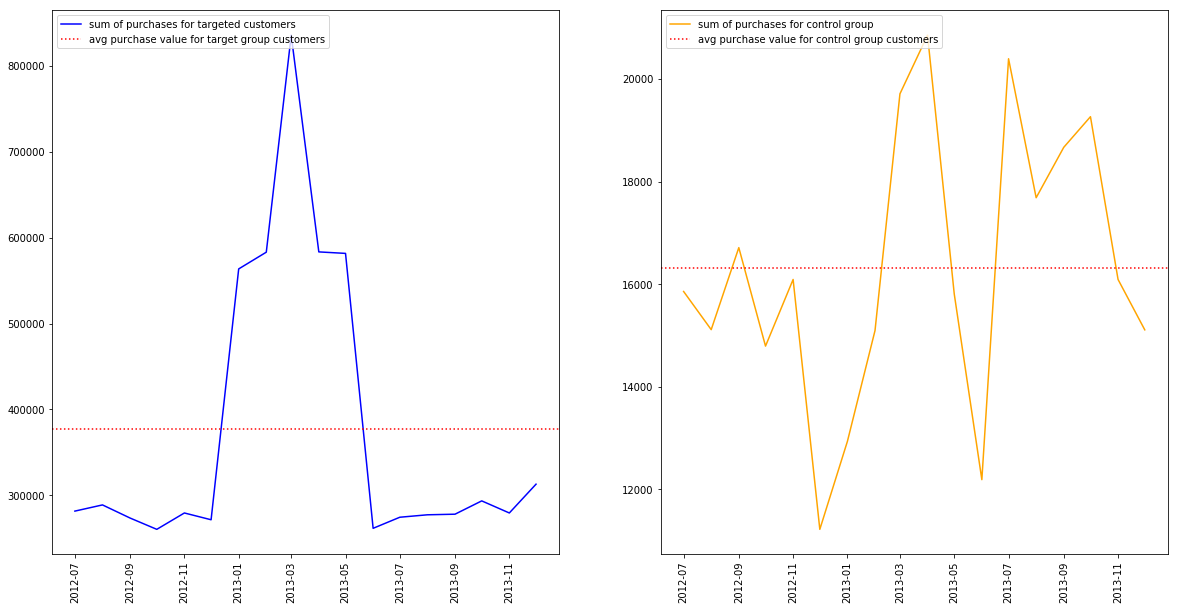

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20,10)

ax1.plot(grouped_tp, color='b',label='sum of purchases for targeted customers')
ax2.plot(grouped_cp,color='orange', label='sum of purchases for control group')
ax1.axhline(mean_tp, color='r',linestyle=':', label='avg purchase value for target group customers')
ax2.axhline(mean_cp, color='r',linestyle=':', label='avg purchase value for control group customers')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.legend(loc='upper left')




I plotted both graphs to further analyse relationships between them. This graph shows that predictive model chose target group well because purchase amounts is significantly higher than in control group.  

(array([734685., 734747., 734808., 734869., 734928., 734989., 735050.,
        735112., 735173.]), <a list of 9 Text xticklabel objects>)

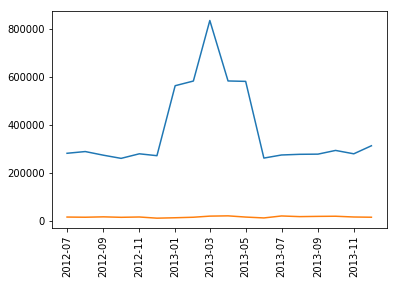

In [8]:
plt.plot(grouped_tp)
plt.plot(grouped_cp)
plt.xticks(rotation='vertical')

### Further analysis of targeted subgroups


I divided target group based on month when the customer was contacted with offer to two subgroups (Jan,Mar).


In [9]:
tp_jan = target_purchases[target_purchases.target_month=='2013-01-01']
tp_mar = target_purchases[target_purchases.target_month=='2013-03-01']



Function to adjust values for discount in given period.

In [10]:
def adjust_for_discount(df, discount_start):
    df2 = df.copy()
    rows = (df2.index >= discount_start) & (df2.index <= (discount_start + relativedelta(months=+2)))
    df2.loc[rows,'purchase_amount'] = df2.loc[rows,'purchase_amount'] * 0.85
    return df2

Then I created grouped data for each customer group and aggregated them in following ways:
* average purchase amounts 
* count of purchases
* sum of purchase amounts

For each created subgroup I filled missing data based on average value. (calculated only from months w/o offer)


In [11]:
#***********************************************************************#
#average purchases
avgtp_jan = tp_jan[['purchase_month','purchase_amount']].groupby(['purchase_month']).mean().sort_values(by='purchase_month')
avgtp_mar = tp_mar[['purchase_month','purchase_amount']].groupby(['purchase_month']).mean().sort_values(by='purchase_month')
#add missing values
#before discount
avgtp_jan = add_mean_values(avgtp_jan)
avgtp_mar = add_mean_values(avgtp_mar)
#after discount
avgtp_jan_after_discount = adjust_for_discount(avgtp_jan,datetime.datetime(2013,1,1))
avgtp_mar_after_discount = adjust_for_discount(avgtp_mar,datetime.datetime(2013,3,1))

#***********************************************************************#
#count of customers
cnttp_jan = tp_jan[['purchase_month','purchase_amount']].groupby(['purchase_month']).count().sort_values(by='purchase_month')
cnttp_mar = tp_mar[['purchase_month','purchase_amount']].groupby(['purchase_month']).count().sort_values(by='purchase_month')
#add missing values
cnttp_jan = add_mean_values(cnttp_jan)
cnttp_mar = add_mean_values(cnttp_mar)


#***********************************************************************#
#sum of purchases
sumtp_jan = tp_jan[['purchase_month','purchase_amount']].groupby(['purchase_month']).sum().sort_values(by='purchase_month')
sumtp_mar = tp_mar[['purchase_month','purchase_amount']].groupby(['purchase_month']).sum().sort_values(by='purchase_month')
#add missing values
#before discount
sumtp_jan = add_mean_values(sumtp_jan)
sumtp_mar = add_mean_values(sumtp_mar)
#after discount
sumtp_jan_after_discount = adjust_for_discount(sumtp_jan,datetime.datetime(2013,1,1))
sumtp_mar_after_discount = adjust_for_discount(sumtp_mar,datetime.datetime(2013,3,1))

Function to plot bar graphs with average line

In [12]:
def plot_bar(ax, data,color,line_label, label):
    ax.bar(data.index,round(data.purchase_amount,2),width=20,color=color,label=label)
    ax.axhline(data.purchase_amount.mean(), color='r',linestyle=':', label=line_label)

#### Average purchase value analysis

From plotted data I did not identify any substantial impact on average purchase amount. It seems that offer did not have effect on value of insurance which customer purchased. However, after we adjust prices for discount (15%), then we can see that customers in average paid less for their insurance because of discount. From this, we can conclude that customers are not likely to buy more expensive insurance even for discounted price. 

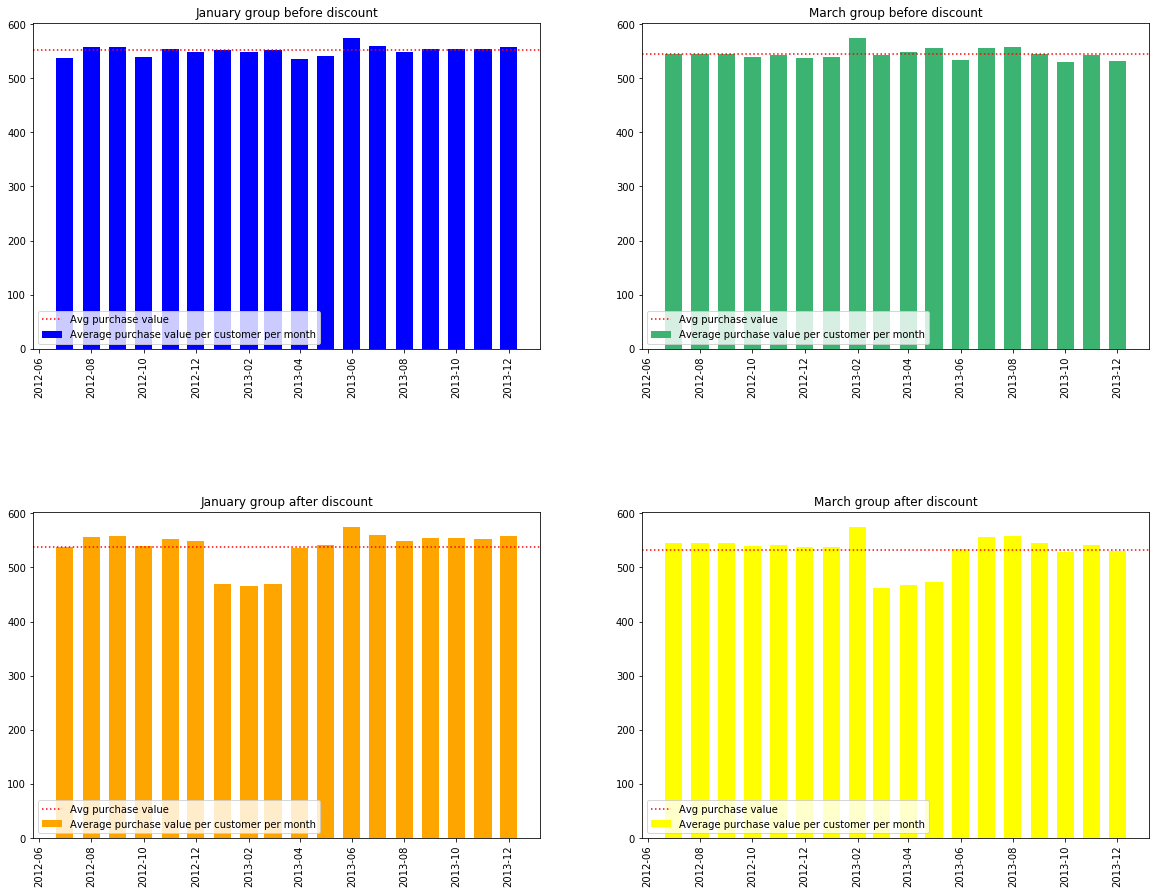

In [13]:
fig,ax = plt.subplots(2, 2)
fig.set_size_inches(20,15)

dfs = [avgtp_jan,avgtp_mar,avgtp_jan_after_discount,avgtp_mar_after_discount]
colors = ['b','mediumseagreen','orange','yellow']
titles = ['January group before discount','March group before discount','January group after discount','March group after discount']

for ax,data,color,title in zip(fig.axes,dfs,colors,titles):
    plot_bar(ax,data,color,'Avg purchase value','Average purchase value per customer per month')
    #display(data)
    plt.sca(ax)
    plt.subplots_adjust(hspace = 0.5)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.legend(loc='lower left')

#### Count of purchases analysis

From plotted data I could see that offer had substantial impact on number of purchases. This graph together with previous graph indicate than offer attracted higher amount of customers. Overall average customer count during offer **increased by 200.02%**

Average customer count per month w/o offer: 257
Average customer count per month with offer: 773
Increase during offer: 200.31 %
**************************************************


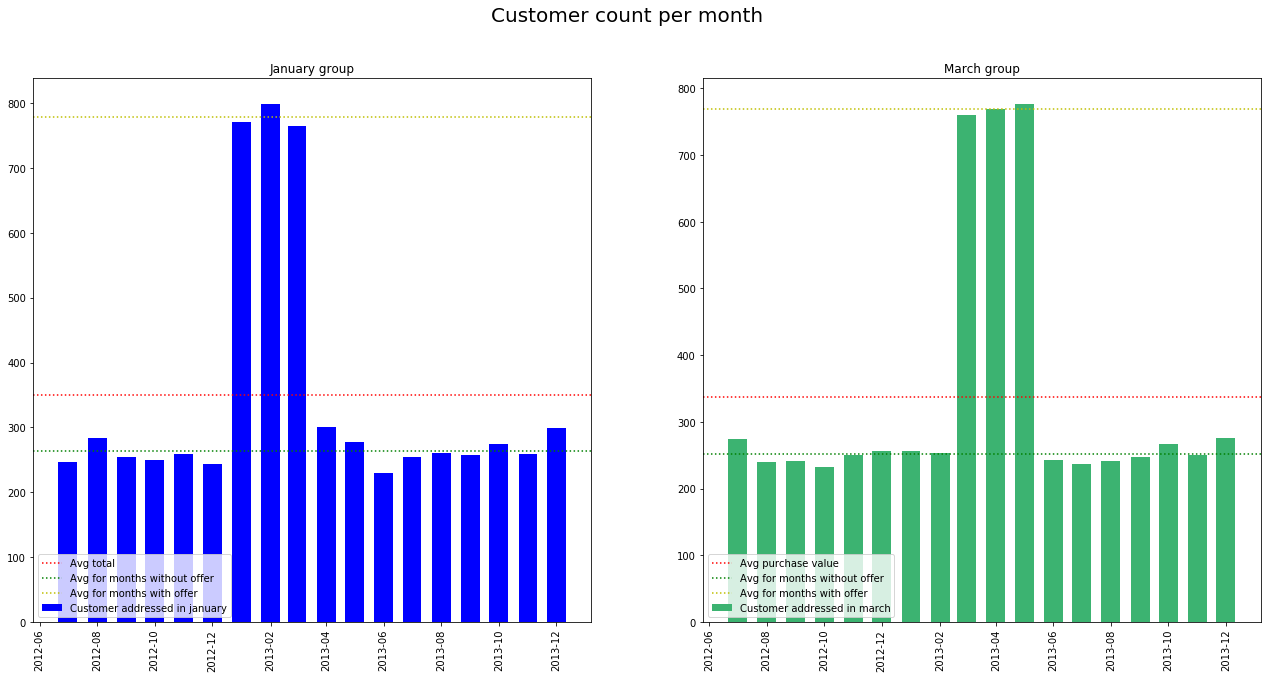

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(22,10)
fig.suptitle('Customer count per month', fontsize=20)

ax1.bar(cnttp_jan.index,round(cnttp_jan.purchase_amount,2),width=20,color='b',label='Customer addressed in january')
ax2.bar(cnttp_mar.index,round(cnttp_mar.purchase_amount,2),width=20,color='mediumseagreen',label='Customer addressed in march')

#january group analysis
jan_wo_offer = cnttp_jan[(cnttp_jan.index < '2013-01-01') | (cnttp_jan.index > '2013-03-01')].purchase_amount.mean()
jan_w_offer = cnttp_jan[(cnttp_jan.index >= '2013-01-01') & (cnttp_jan.index <= '2013-03-01')].purchase_amount.mean()
ax1.axhline(cnttp_jan.purchase_amount.mean(), color='r',linestyle=':', label='Avg total')
ax1.axhline(jan_wo_offer, color='g',linestyle=':', label='Avg for months without offer')
ax1.axhline(jan_w_offer, color='y',linestyle=':', label='Avg for months with offer')

#march group analysis
mar_wo_offer = cnttp_mar[(cnttp_mar.index < '2013-03-01') | (cnttp_mar.index > '2013-05-01')].purchase_amount.mean()
mar_w_offer = cnttp_mar[(cnttp_mar.index >= '2013-03-01') & (cnttp_mar.index <= '2013-05-01')].purchase_amount.mean()
ax2.axhline(cnttp_mar.purchase_amount.mean(), color='r',linestyle=':', label='Avg purchase value')
ax2.axhline(mar_wo_offer, color='g',linestyle=':', label='Avg for months without offer')
ax2.axhline(mar_w_offer, color='y',linestyle=':', label='Avg for months with offer')

titles = ['January group','March group']

#plot
for ax,title in zip(fig.axes,titles):
    plt.sca(ax)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.legend(loc='lower left')
    
#print data
avg_w_offer = (jan_w_offer+mar_w_offer)/2
avg_wo_offer = (jan_wo_offer+mar_wo_offer)/2
print('Average customer count per month w/o offer:',round(avg_wo_offer) )
print('Average customer count per month with offer:',round(avg_w_offer) )
print('Increase during offer:',round(((avg_w_offer - avg_wo_offer)/avg_wo_offer)*100,2),'%')
print('*'*50)


#### Sum of purchase amount analysis

Similarly as with average purchase amount per customer per month, I analysed sum of purchase amounts per month. In graphs below we can see total purchase amounts before and after discount for each group (Jan/Mar).

From this graph and using knowledge from previous graphs, we can see that although average purchase amount "decreased" (because customers payed less due to discount), overall purchase count **increased significantly** and thus, overall purchase amounts increased too. This is positive sign that discount offer campain was successful. 

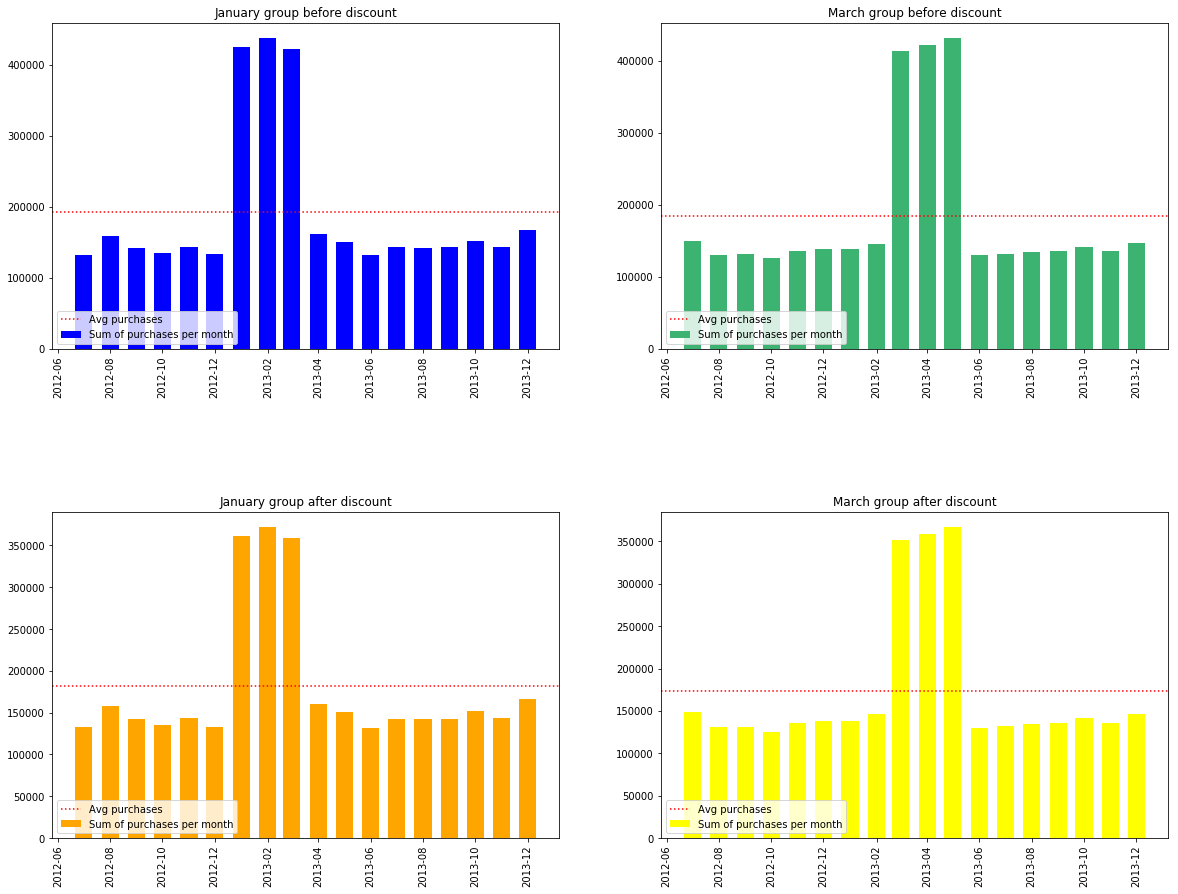

In [15]:
fig,ax = plt.subplots(2, 2)
fig.set_size_inches(20,15)

dfs = [sumtp_jan,sumtp_mar,sumtp_jan_after_discount,sumtp_mar_after_discount]
colors = ['b','mediumseagreen','orange','yellow']
titles = ['January group before discount','March group before discount','January group after discount','March group after discount']

for ax,data,color,title in zip(fig.axes,dfs,colors,titles):
    plot_bar(ax,data,color,'Avg purchases', 'Sum of purchases per month')
    #display(data)
    plt.sca(ax)
    plt.subplots_adjust(hspace = 0.5)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.legend(loc='lower left')

##### Further analysis of purchase amounts 
I plotted January and March group **after discount** into the graph. As with count of customers, I calculated mean for months when discount was present and mean for months where discount was present. From this I could calculate increase in purchases due to discount offer. It seems that offer generated **increase in purchase amounts by 156%**.

Average purchase amount per month w/o offer: 141013
Average purchase amount per month with offer: 361447
Increase during offer: 156.32 %
**************************************************


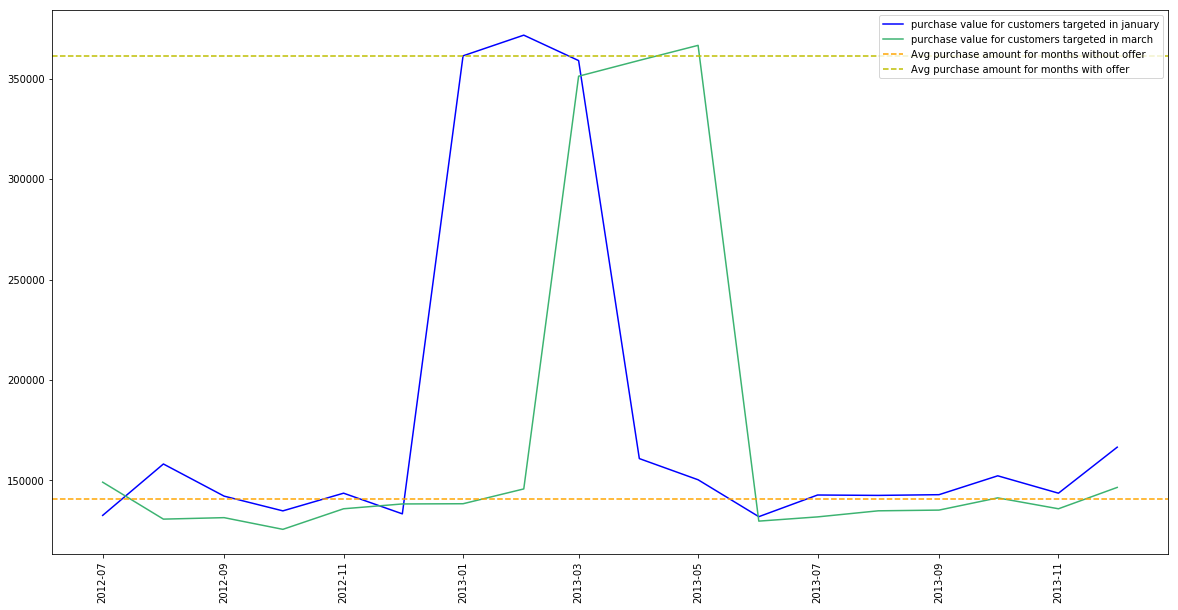

In [16]:
#january group
jan_wo_offer = sumtp_jan_after_discount[(sumtp_jan_after_discount.index < '2013-01-01') | (sumtp_jan_after_discount.index > '2013-03-01')].purchase_amount.mean()
jan_w_offer = sumtp_jan_after_discount[(sumtp_jan_after_discount.index >= '2013-01-01') & (sumtp_jan_after_discount.index <= '2013-03-01')].purchase_amount.mean()

#march group
mar_wo_offer = sumtp_mar_after_discount[(sumtp_mar_after_discount.index < '2013-03-01') | (sumtp_mar_after_discount.index > '2013-05-01')].purchase_amount.mean()
mar_w_offer = sumtp_mar_after_discount[(sumtp_mar_after_discount.index >= '2013-03-01') & (sumtp_mar_after_discount.index <= '2013-05-01')].purchase_amount.mean()

#overall mean for months without offer
sum_wo_offer = (jan_wo_offer + mar_wo_offer)/2
#overall mean for months with offer
sum_w_offer = (jan_w_offer + mar_w_offer)/2


#plot
plt.figure(figsize=(20,10))
plt.plot(sumtp_jan_after_discount,color='b', label='purchase value for customers targeted in january')
plt.plot(sumtp_mar_after_discount,color='mediumseagreen',label='purchase value for customers targeted in march')
#overall mean
#plt.axhline(sumtp_jan_after_discount.purchase_amount.mean(), color='r',linestyle=':', label='Avg overall purchase amount')
plt.axhline(sum_wo_offer, color='orange',linestyle='--', label='Avg purchase amount for months without offer')
plt.axhline(sum_w_offer, color='y',linestyle='--', label='Avg purchase amount for months with offer')

plt.xticks(rotation='vertical')
plt.legend(loc='upper right')

#print
print('Average purchase amount per month w/o offer:',round(sum_wo_offer) )
print('Average purchase amount per month with offer:',round(sum_w_offer) )
print('Increase during offer:',round(((sum_w_offer - sum_wo_offer)/sum_wo_offer)*100,2),'%')
print('*'*50)

### Additional information about targeted customers

From all targeted customers, I tried to find out, how many of them purchased insurance only during offer, how many took advatage of discount and how many of the targeted customers made purchase also when offer was not running. **Out of 9000 targeted customers, 6557 (73%) made some kind of purchase** during given scope. This means that predictive model for targeting customers works well. I identified **noteworthy increase (184%)** for unique customer purchases during time when offer was running. Also **8% (757 out of 9000)** of total targeted customers purchased insurance **only during campain**.

In [17]:
all_targeted = target_purchases.customer_id.unique()
buying_customers_during_offer = target_purchases[((target_purchases.target_month=='2013-01-01') & (target_purchases.purchase_month >= '2013-01-01') & (target_purchases.purchase_month <= '2013-03-01')) | ((target_purchases.target_month=='2013-03-01') & (target_purchases.purchase_month >= '2013-03-01') & (target_purchases.purchase_month <= '2013-05-01')) ].customer_id.unique()
buying_customers_except_offer = target_purchases[((target_purchases.target_month=='2013-01-01') | (target_purchases.purchase_month < '2013-01-01') & (target_purchases.purchase_month > '2013-03-01')) & ((target_purchases.target_month=='2013-03-01') & (target_purchases.purchase_month < '2013-03-01') | (target_purchases.purchase_month > '2013-05-01')) ].customer_id.unique()
buying_customers_except_offer = pd.Series(buying_customers_except_offer)
only_during_discount = len(buying_customers_except_offer[~buying_customers_except_offer.isin(buying_customers_during_offer)])



print('Additional info','*'*34)
print('Targeted overall:', 9000)
print('Targeted customers who purchased during scope:',len(all_targeted))
print('Target customer conversion rate:', round((len(all_targeted)/9000),2)*100,'%')
print()
print('Customers purchased when no offer was valid:',len(buying_customers_except_offer))
print('Customers purchased during offer:',len(buying_customers_during_offer))
print('Increase in unique customers who purchased:',round(((len(buying_customers_during_offer)-len(buying_customers_except_offer))/len(buying_customers_except_offer))*100,2),'%')
print()
print('Customers who purchased only during discount:',only_during_discount)
print('Discount offer conversion rate:',round(only_during_discount/9000,2)*100,'%' )

print('*'*50)
print()

Additional info **********************************
Targeted overall: 9000
Targeted customers who purchased during scope: 6557
Target customer conversion rate: 73.0 %

Customers purchased when no offer was valid: 1347
Customers purchased during offer: 3832
Increase in unique customers who purchased: 184.48 %

Customers who purchased only during discount: 757
Discount offer conversion rate: 8.0 %
**************************************************



### Results

#### Impact of campain:
* **total expenses**: 173 000 CZK
* **total customer increase during campain** : 200,03%
* **total purchase amount increase during campain** : 156,36%
* **profitable margin on product must be greater than** : 13% 
* **new customers gained**: 757 (8% out of 9000 targeted)




**Total expenses** were calculated as fixed expenses (38 000 CZK) plus variable expenses ( 15 CZK times number of targeted customers - 9000)

**Total purchase amount gained** is amount which is generated by discount offer. I used average purchase amount  for months without offer (*orange line* in graph above) as predictor. Everything over this line I took as amounts generated by the offer. 

**Profitable margin** - I calculated profitable margin with following formula: 


\begin{equation*}
margin  > \frac{total\_expenses}{purchase\_amount\_gained} 
\end{equation*}

In [18]:
sumtp_jan_after_discount['profit'] = sumtp_jan_after_discount['purchase_amount'] - sum_wo_offer
sumtp_mar_after_discount['profit'] = sumtp_mar_after_discount['purchase_amount'] - sum_wo_offer

#purchase amount gain for january group 
tp_jan_pag = sumtp_jan_after_discount['profit'][(sumtp_jan_after_discount.index >= '2013-01-01') & (sumtp_jan_after_discount.index <= '2013-03-01')].sum()

#purchase amount gain for march group 
tp_mar_pag = sumtp_mar_after_discount['profit'][(sumtp_mar_after_discount.index >= '2013-03-01') & (sumtp_mar_after_discount.index <= '2013-05-01')].sum()

total_pag = tp_jan_pag + tp_mar_pag

fixed_expenses = 38000
variable_expenses= 15 * 9000
total_expenses = fixed_expenses + variable_expenses


print('Purchase amount gain','*'*29)
print('January group purchase amount gain:',round(tp_jan_pag),'CZK' )
print('March group purchase amount gain:',round(tp_mar_pag),'CZK' )
print('*'*50)
print()
print('Expenses','*'*41)
print('Fixed expenses:',fixed_expenses,'CZK' )
print('Variable expenses:',variable_expenses,'CZK' )
print('*'*50)
print()
print('Overview','*'*41)
print('Total purchase amount gain:',round(total_pag),'CZK' )
print('Total expenses:',total_expenses,'CZK' )

print('*'*50)
print('Profitable murgin must be grater than:' ,round(total_expenses/total_pag,2))

Purchase amount gain *****************************
January group purchase amount gain: 668864.0 CZK
March group purchase amount gain: 653739.0 CZK
**************************************************

Expenses *****************************************
Fixed expenses: 38000 CZK
Variable expenses: 135000 CZK
**************************************************

Overview *****************************************
Total purchase amount gain: 1322604.0 CZK
Total expenses: 173000 CZK
**************************************************
Profitable murgin must be grater than: 0.13
